
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,auc
from plotnine import *

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha_clean = ha.dropna()
ha_clean

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [3]:
from sklearn.metrics import accuracy_score

# Perform train-test split
X = ha_clean.drop(columns=["cp"])
y = ha_clean["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Define the preprocessing and model pipeline
knn = KNeighborsClassifier()
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), ["sex", "output", "restecg"]),
    ],
    remainder="passthrough"
)

knn_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Knn", knn)
    ]
)

# Hyperparameter tuning with GridSearchCV
k = {"Knn__n_neighbors": np.arange(1, 50)}
gscv = GridSearchCV(knn_pipeline, k, cv=5, scoring="accuracy")  # Change scoring to "accuracy"
gscv.fit(X_train, y_train)

# Extract the best number of neighbors
best_k = gscv.best_params_["Knn__n_neighbors"]

# Build the best model pipeline
best_k_model = Pipeline(
    [
        ("preprocessing", ct),
        ("Knn", KNeighborsClassifier(n_neighbors=best_k))
    ]
)

# Fit the model on the training set
best_model = best_k_model.fit(X_train, y_train)

# Predict on the test data
y_test_pred = best_model.predict(X_test)

# Compute and print the accuracy score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Cross-validated Accuracy of the best model: {gscv.best_score_:.4f}")
print(f"Accuracy on the test data: {test_accuracy:.4f}")
print(f"Best value for k: {best_k}")
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)


Cross-validated Accuracy of the best model: 0.5928
Accuracy on the test data: 0.5362
Best value for k: 19
Confusion Matrix:
[[24  3  5  0]
 [ 5  4  2  0]
 [ 9  3  9  0]
 [ 0  0  5  0]]
Cross-validated Accuracy of the best model: 0.5928
Accuracy on the test data: 0.5362
Best value for k: 19
Confusion Matrix:
[[24  3  5  0]
 [ 5  4  2  0]
 [ 9  3  9  0]
 [ 0  0  5  0]]


In [4]:

# Perform train-test split
X = ha_clean.drop(columns=["cp"])
y = ha_clean["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# Define the preprocessing and model pipeline
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), ["sex", "output", "restecg"]),
    ],
    remainder="passthrough"
)

dt_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("DT", DecisionTreeClassifier(random_state=42))
    ]
)

# Hyperparameter tuning with GridSearchCV
param_grid = {"DT__max_depth": np.arange(1, 21)}
gscv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring="accuracy")
gscv.fit(X_train, y_train)

# Extract the best max_depth
best_tree_depth = gscv.best_params_["DT__max_depth"]

# Build the best model pipeline
best_tree_model = Pipeline(
    [
        ("preprocessing", ct),
        ("DT", DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42))
    ]
)

# Fit the model on the training set
final_model = best_tree_model.fit(X_train, y_train)

# Predict on the test data
y_test_pred = final_model.predict(X_test)

# Compute and print the accuracy score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Cross-validated accuracy of the best model: {gscv.best_score_:.4f}")
print(f"Accuracy on the test data: {test_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
best_tree_depth


Cross-validated accuracy of the best model: 0.5833
Accuracy on the test data: 0.5507
Confusion Matrix:
[[24  0  8  0]
 [ 4  0  7  0]
 [ 7  0 14  0]
 [ 0  0  5  0]]
Cross-validated accuracy of the best model: 0.5833
Accuracy on the test data: 0.5507
Confusion Matrix:
[[24  0  8  0]
 [ 4  0  7  0]
 [ 7  0 14  0]
 [ 0  0  5  0]]


1

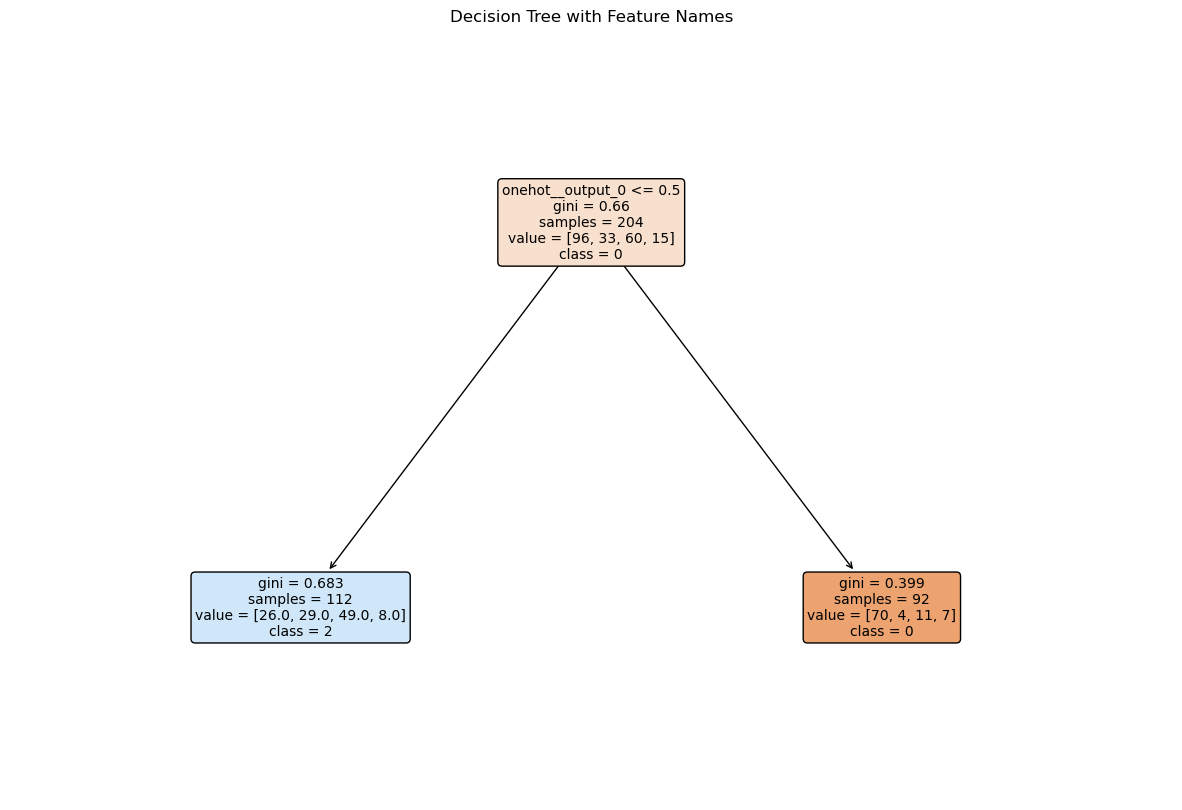

In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the feature names after preprocessing
feature_names = ct.get_feature_names_out()

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(
    final_model.named_steps["DT"],
    feature_names=feature_names,
    class_names=[str(cls) for cls in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree with Feature Names")
plt.show()


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [11]:
ha_clean["cp_is_3"] = (ha_clean["cp"] == 3).astype(int)
X = ha_clean.drop(columns=["cp","cp_is_3"])
y = ha_clean["cp_is_3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logistic", LogisticRegression())
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(log_pipeline,params, cv=5,scoring="f1")
best_log_model = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best F1 Score (cp = 3): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 0.01}
Best F1 Score (cp = 3): 0.0
Best Logistic parameters: {'logistic__C': 0.01}
Best F1 Score (cp = 3): 0.0


In [12]:
ha_clean["cp_is_2"] = (ha_clean["cp"] == 2).astype(int)
X = ha_clean.drop(columns=["cp","cp_is_2"])
y = ha_clean["cp_is_2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logistic", LogisticRegression())
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(log_pipeline,params, cv=5,scoring="f1")
best_log_model = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best F1 Score (cp = 2): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 100}
Best F1 Score (cp = 2): 0.22848527969540217
Best Logistic parameters: {'logistic__C': 100}
Best F1 Score (cp = 2): 0.22848527969540217


In [13]:
ha_clean["cp_is_1"] = (ha_clean["cp"] == 1).astype(int)
X = ha_clean.drop(columns=["cp","cp_is_1"])
y = ha_clean["cp_is_1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logistic", LogisticRegression())
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(log_pipeline,params, cv=5,scoring="f1")
best_log_model = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best F1 Score (cp = 1): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 10}
Best F1 Score (cp = 1): 0.45082251082251085
Best Logistic parameters: {'logistic__C': 10}
Best F1 Score (cp = 1): 0.45082251082251085


In [17]:
ha_clean["cp_is_0"] = (ha_clean["cp"] == 0).astype(int)
X = ha_clean.drop(columns=["cp","cp_is_0"])
y = ha_clean["cp_is_0"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logistic", LogisticRegression())
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(log_pipeline,params, cv=5,scoring="f1")
best_log_model = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best F1 Score (cp = 0): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 10}
Best F1 Score (cp = 0): 1.0
Best Logistic parameters: {'logistic__C': 10}
Best F1 Score (cp = 0): 1.0


Based on the models for each of the cp categories the best one was the last one when cp = 0 but the f1 score is 1 which means it classified all the cases prefectly which is unlikely.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [25]:
data_1 = ha_clean[(ha_clean['cp'] == 1) | (ha_clean['cp'] == 0)]
X = data_1.drop(columns=["cp","cp_is_3","cp_is_2","cp_is_1","cp_is_0"])
y = data_1["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
logistic = Pipeline(
    [
        ("preprocessing",ct),
        ("logistic",LogisticRegression(max_iter=1000))
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(logistic,params,cv=5,scoring="roc_auc")
best_logistic = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best ROC AUC (0-1): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 0.1}
Best ROC AUC (0-1): 0.8503634085213033
Best Logistic parameters: {'logistic__C': 0.1}
Best ROC AUC (0-1): 0.8503634085213033


In [26]:
data_1 = ha_clean[(ha_clean['cp'] == 2) | (ha_clean['cp'] == 0)]
X = data_1.drop(columns=["cp","cp_is_3","cp_is_2","cp_is_1","cp_is_0"])
y = data_1["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
logistic = Pipeline(
    [
        ("preprocessing",ct),
        ("logistic",LogisticRegression(max_iter=1000))
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(logistic,params,cv=5,scoring="roc_auc")
best_logistic = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best ROC AUC (0-1): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 1}
Best ROC AUC (0-1): 0.7389473684210526
Best Logistic parameters: {'logistic__C': 1}
Best ROC AUC (0-1): 0.7389473684210526


In [27]:
data_1 = ha_clean[(ha_clean['cp'] == 3) | (ha_clean['cp'] == 0)]
X = data_1.drop(columns=["cp","cp_is_3","cp_is_2","cp_is_1","cp_is_0"])
y = data_1["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
logistic = Pipeline(
    [
        ("preprocessing",ct),
        ("logistic",LogisticRegression(max_iter=1000))
    ]
)
params = {"logistic__C":[0.01,0.1,1,10,100]}
logistic_gscv = GridSearchCV(logistic,params,cv=5,scoring="roc_auc")
best_logistic = logistic_gscv.fit(X_train,y_train)
print(f"Best Logistic parameters: {logistic_gscv.best_params_}")
print(f"Best ROC AUC (0-1): {logistic_gscv.best_score_}")

Best Logistic parameters: {'logistic__C': 0.1}
Best ROC AUC (0-1): 0.8135087719298246
Best Logistic parameters: {'logistic__C': 0.1}
Best ROC AUC (0-1): 0.8135087719298246


OvO was best at distinguishing when only a chest pain of 0 and 1 are in the model.